In [1]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import utils.saver as saver
import system.from_higher_basis_truncation_tunable_full_cosine as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as tukey
importlib.reload(tukey)
import pulse.tanh as tanh
importlib.reload(tanh)
import utils.expectation_values as expv
importlib.reload(expv)
import utils.diagonalize as diagonalize
importlib.reload(diagonalize)

pass

In [2]:
from qutip.parallel import parallel_map as parallel_map
from tqdm import tqdm
# _amplitude = 1 * 2 * np.pi
_num_of_points = 400
_offset_offset = 1.1
_duration_range = np.linspace(25, 250, int(_num_of_points/4))
_t_multiplier = 2
_starting_state = system.basis_states[0]
_target_state = system.basis_states[0]

# original data trying to replicate tanh pulse
_amplitude = 11.100294042683936
# center_offset = 0.2628912071535022


In [3]:
# Tukey Parameters
_ramp_coef = 0.5

# Tanh Parameters
_ramp_slope = 0.5
_cut_factor = 3

# Find Offset Center

for duration = 36.363636
10.0%. Run time:   1.61s. Est. time left: 00:00:00:14
20.0%. Run time:   2.30s. Est. time left: 00:00:00:09
30.0%. Run time:   3.77s. Est. time left: 00:00:00:08
40.0%. Run time:   4.49s. Est. time left: 00:00:00:06
50.0%. Run time:   6.06s. Est. time left: 00:00:00:06
60.0%. Run time:   7.04s. Est. time left: 00:00:00:04
70.0%. Run time:   8.60s. Est. time left: 00:00:00:03
80.0%. Run time:   9.49s. Est. time left: 00:00:00:02
90.0%. Run time:  11.39s. Est. time left: 00:00:00:01
100.0%. Run time:  12.76s. Est. time left: 00:00:00:00
Total run time:  12.77s


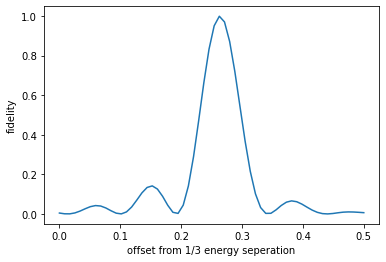

In [4]:
# _random_duration = np.random.choice(_duration_range, 1)[0]
_random_duration = _duration_range[5]
print("for duration = %f" % _random_duration)
def vary_offset_tukey(off):
    tlist = np.linspace(0, _random_duration, int(_random_duration*_t_multiplier))
    tukey.setup(amplitude=_amplitude, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
    }

offs_to_test = np.linspace(0, 0.5, 60)
offset_varying_results = parallel_map(vary_offset_tukey, offs_to_test, progress_bar=True)
_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])
plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.xlabel("offset from 1/3 energy seperation")
plt.ylabel("fidelity")
plt.show()

_center_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
_offset_range = np.linspace(_center_offset - _offset_offset, _center_offset + _offset_offset, _num_of_points )

In [5]:
offset_varying_results[np.argmax(_fids_off_sweep)]["offset"] # 0.2628912071535022

0.2627118644067797

# Define evaluation functions

In [6]:
_current_offset = _offset_range[0]

In [7]:
def tukey_eval(dur):
    tlist = np.linspace(0, dur, int(dur*_t_multiplier))
    tukey.setup(amplitude=_amplitude, drive_frequency= system.first_energy_spacing/3 - _current_offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=_starting_state, pbar=False, store_states=False)
    return {
        # "states": solution.states,
        "final_state": solution.final_state,
        "offset": _current_offset,
        "frequency":  system.first_energy_spacing/3 - _current_offset,
        "duration": dur,
        "amplitude": _amplitude,
        "ramp_coef": _ramp_coef
    }

In [8]:
def tanh_eval(dur):
    tlist = np.linspace(0, dur, int(dur*_t_multiplier))
    tanh.setup(_amplitude, system.first_energy_spacing/3 - _current_offset, _ramp_slope, _cut_factor, tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=_starting_state, pbar=False, store_states=False)
    return {
        # "states": solution.states,
        "final_state": solution.final_state,
        "offset": _current_offset,
        "frequency":  system.first_energy_spacing/3 - _current_offset,
        "duration": dur,
        "amplitude": _amplitude,
        "ramp_coef": _ramp_coef
    }

## Compare Tukey vs Tanh pulse
1. Tanh will keep a consistent ramp up/down time as we increase duration, but I believe it takes longer to compute.
2. Tukey will keep a consistent % of the pulse as ramp up/down and I think it is faster.

In [9]:
# tukey_results = []
# for off in tqdm(_offset_range):
#     _current_offset = off
#     tukey_results += parallel_map(tukey_eval, _duration_range)

In [10]:
tanh_results = []
for off in tqdm(_offset_range):
    _current_offset = off
    tanh_results += parallel_map(tanh_eval, _duration_range)

100%|██████████| 400/400 [9:31:51<00:00, 85.78s/it]


In [12]:
saver.save_via_dill(tanh_results, "psi0_tanh_flattop_landscape_oct32_HD")

# Analyze Landscapes with varying degrees of $\Psi_1 + \Psi_0$

In [37]:
# psi0_landscape = saver.load_via_dill("psi0_tukey_flattop_landscape_oct19")
# psi1_landscape = saver.load_via_dill("psi1_tanh_flattop_landscape_oct27_HD")
psi1_landscape = saver.load_via_dill("psi1_tanh_flattop_landscape_oct27_HD")

In [40]:
amp = psi1_landscape[0]["amplitude"]
durs = []
freqs = []
psi0_fstates = []
psi1_fstates = []
psi0_fid = []
psi1_fid = []

_target_state = system.basis_states[1]
for i in range(0, len(psi1_landscape)):
    amp = psi1_landscape[i]["amplitude"]
    durs.append(psi1_landscape[i]["duration"])
    freqs.append(psi1_landscape[i]["frequency"])
    # psi0_fstates.append(psi0_landscape[i]["final_state"])
    psi1_fstates.append(psi1_landscape[i]["final_state"])
    # psi0_fid.append(expv.expectation_value(psi0_landscape[i]["final_state"], fid_target_state))
    psi1_fid.append(expv.expectation_value(psi1_landscape[i]["final_state"], _target_state))

Text(0, 0.5, 'ns')

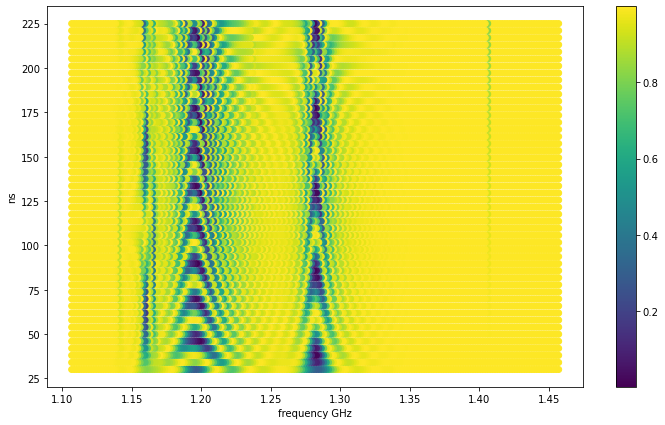

In [41]:
plt.figure(figsize=(12,7))
plt.scatter(np.array(freqs)/(2*np.pi), durs, c=np.array(psi1_fid))
plt.colorbar()
plt.xlabel("frequency GHz")
plt.ylabel("ns")

0.0945820629843007


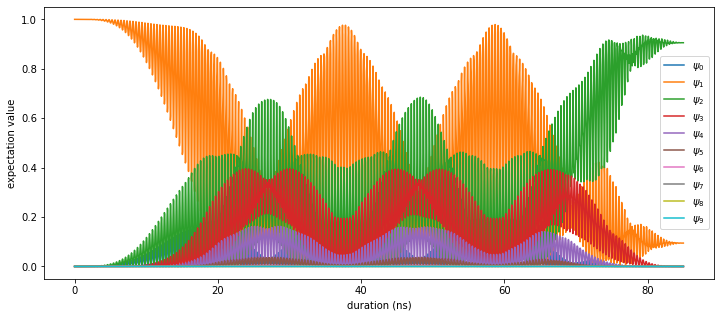

In [81]:
import utils.graph as graph
_t_max = 85
#offset = 0.3898644953695122
#freq = system.first_energy_spacing/3 - offset
freq = 7.52
durations = np.arange(0, _t_max, (2*np.pi)/(freq*20))
amp = 11.100294042683936

tukey.setup(amp, freq, 0.5, durations)

s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, durations, system.target_state, pbar=True)

graph.graph_solution(s, system)
print(expv.expectation_value(s.final_state, system.target_state))

0.9436223730160216


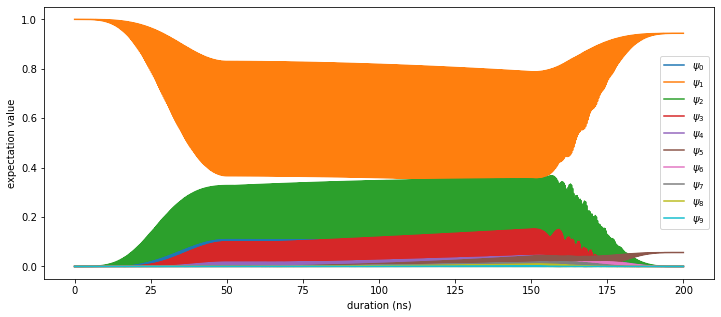

In [111]:
import utils.graph as graph
_t_max = 200
#offset = 0.3898644953695122
#freq = system.first_energy_spacing/3 - offset
#  8.822853550769953,
#  8.833908827151863,
#  8.844964103533773,
freq = 8.833908827151863
durations = np.arange(0, _t_max, (2*np.pi)/(freq*20))
amp = 11.100294042683936

tukey.setup(amp, freq, 0.5, durations)

s = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, durations, system.target_state, pbar=True)

graph.graph_solution(s, system)
print(expv.expectation_value(s.final_state, system.target_state))